# Table of Contents
1. [Introduction](#introduction)
2. [Data](#data)
3. [Factors](#factors)
4. [Volatility Scaling](#volatility-scaling)
5. [Robusness Checks](#robustness-checks)

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import VolatilityManagedPortfolio as vmp

In [2]:
price= pd.read_csv("Data\price.csv", index_col="Date", parse_dates=True).loc["2014":"2022"]
marketCap= pd.read_csv("Data\marketCap.csv", index_col="Date", parse_dates=True).loc["2014":"2022"]
Volume= pd.read_csv("Data\Volume.csv", index_col="Date", parse_dates=True).loc["2014":"2022"]
RF_D = pd.read_csv("Data\F-F_Research_Data_Factors_daily.csv", index_col="date", parse_dates=True, date_format="%Y%m%d").loc["2014":"2022"]/100

<span id="introduction" style="font-size: 24px; font-weight: bold; color: purple;">Introduction:</span>

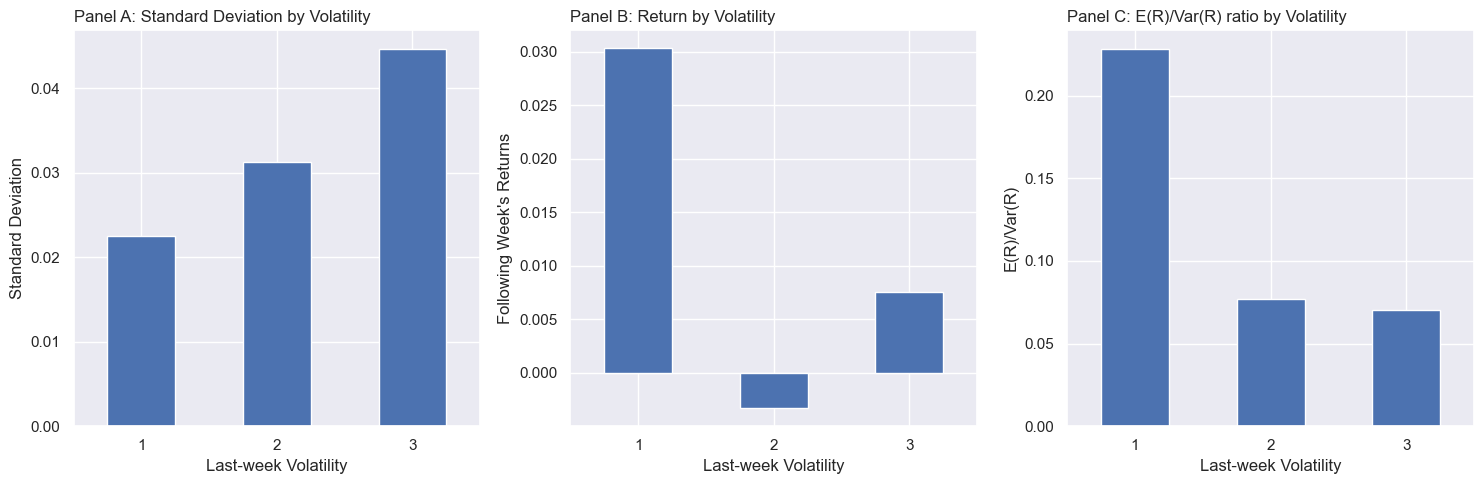

In [3]:
vmp.plot_Risk_Return(price,marketCap,q=3, save=True)

<span id="data" style="font-size: 24px; font-weight: bold; color: purple;">Data:</span>

In [4]:
filter = (marketCap>=0) & (Volume>=0) & (price<marketCap)
price = price[filter].dropna(axis=1,how="all")
marketCap = marketCap[filter].dropna(axis=1,how="all")
Volume = Volume[filter].dropna(axis=1,how="all")

price[marketCap==0] = 0
marketCap[price==0] = 0

len(price.columns)

3061

In [5]:
ret_W = vmp.price2ret(price) # weekly returns
ret_D = vmp.price2ret(price, period="D") # daily returns

weekend_marketCap = marketCap.fillna(-np.inf).resample("W").last().replace(-np.inf,np.nan) # to use in factors building
weekly_Volume = Volume.resample("W").sum().replace(0,np.nan) # to use in factors building

weekend_price = price.fillna(-np.inf).resample("W").last().replace(-np.inf,np.nan) #to use in building momentum factors

RF_W = (1+RF_D).resample("W").prod()-1 # weekly risk-free rate

<span id="factors" style="font-size: 24px; font-weight: bold; color: purple;">Factors:</span>

In [6]:
# CMKT
CMKT_weight = weekend_marketCap.div(weekend_marketCap.sum(axis=1), axis=0).replace(0, np.nan).shift(1)
CMKT_ret = pd.DataFrame(vmp.calculate_portfolio_returns(ret_W, CMKT_weight, factor="CMKT").CMKT - RF_W.RF, columns=["CMKT"])
CMKT_weight_D = marketCap.div(marketCap.sum(axis=1), axis=0).replace(0, np.nan).shift(1)
CMKT_ret_D = pd.DataFrame(vmp.calculate_portfolio_returns(ret_D, CMKT_weight_D, factor="CMKT").CMKT - RF_D.RF, columns=["CMKT"])

# Factors
CSMB = marketCap.fillna(-np.inf).resample("W").last().replace(-np.inf, np.nan) # CSMB
CMOM = (weekend_price/weekend_price.shift(3))-1 # CMOM
MCAP = np.log(marketCap.fillna(-np.inf).resample("W").last().replace(-np.inf, np.nan)) # MCAP: Log last day market capitalization in the portfolio formation week
PRC = np.log(price.fillna(-np.inf).resample("W").last().replace(-np.inf, np.nan)) # PRC: Log last day price in the portfolio formation week
MAXDPRC = price.resample("W").max() # MAXDPRC: The maximum price of the portfolio formation week
r_1_0 = ret_W # r_1_0: 1-week momentum
r_2_0 = (weekend_price/weekend_price.shift(2))-1 # r_2_0: 2-week momentum
r_3_0 = (weekend_price/weekend_price.shift(3))-1 # r_3_0: 3-week momentum
r_4_0 = (weekend_price/weekend_price.shift(4))-1 # r_4_0: 4-week momentum
PRCVOL = np.log((price*Volume).resample("W").mean()) # PRCVOL: Log average daily volume times price in the portfolio formation week
STDPRCVOL = np.log((price*Volume).resample("W").std()) # STDPRCVOL: Log standard deviation of dollar volume in the portfolio formation week

# Factors_weekly_weights
CSMB_weight = -vmp.calculate_weights(CSMB, weekend_marketCap, weekly_Volume, low=0.3, high=0.7)
CMOM_weight = vmp.calculate_weights(CMOM, weekend_marketCap, weekly_Volume, low=0.3, high=0.7)
MCAP_weight = -vmp.calculate_weights(MCAP, weekend_marketCap, weekly_Volume)
PRC_weight = -vmp.calculate_weights(PRC, weekend_marketCap, weekly_Volume)
MAXDPRC_weight = -vmp.calculate_weights(MAXDPRC, weekend_marketCap, weekly_Volume)
r_1_0_weight = vmp.calculate_weights(r_1_0, weekend_marketCap, weekly_Volume)
r_2_0_weight = vmp.calculate_weights(r_2_0, weekend_marketCap, weekly_Volume)
r_3_0_weight = vmp.calculate_weights(r_3_0, weekend_marketCap, weekly_Volume)
r_4_0_weight = vmp.calculate_weights(r_4_0, weekend_marketCap, weekly_Volume)
PRCVOL_weight = -vmp.calculate_weights(PRCVOL, weekend_marketCap, weekly_Volume)
STDPRCVOL_weight = -vmp.calculate_weights(STDPRCVOL, weekend_marketCap, weekly_Volume)

# Factors_weekly_returns
CSMB_ret = vmp.calculate_portfolio_returns(ret_W, CSMB_weight, factor="CSMB")
CMOM_ret = vmp.calculate_portfolio_returns(ret_W, CMOM_weight, factor="CMOM")
MCAP_ret = vmp.calculate_portfolio_returns(ret_W, MCAP_weight, factor="MCAP")
PRC_ret = vmp.calculate_portfolio_returns(ret_W, PRC_weight, factor="PRC")
MAXDPRC_ret = vmp.calculate_portfolio_returns(ret_W, MAXDPRC_weight, factor="MAXDPRC")
r_1_0_ret = vmp.calculate_portfolio_returns(ret_W, r_1_0_weight, factor="r_1_0")
r_2_0_ret = vmp.calculate_portfolio_returns(ret_W, r_2_0_weight, factor="r_2_0")
r_3_0_ret = vmp.calculate_portfolio_returns(ret_W, r_3_0_weight, factor="r_3_0")
r_4_0_ret = vmp.calculate_portfolio_returns(ret_W, r_4_0_weight, factor="r_4_0")
PRCVOL_ret = vmp.calculate_portfolio_returns(ret_W, PRCVOL_weight, factor="PRCVOL")
STDPRCVOL_ret = vmp.calculate_portfolio_returns(ret_W, STDPRCVOL_weight, factor="STDPRCVOL")

# Factors_daily_weights
CSMB_weight_D = CSMB_weight.resample("D").bfill(limit=6)
CMOM_weight_D = CMOM_weight.resample("D").bfill(limit=6)
MCAP_weight_D = MCAP_weight.resample("D").bfill(limit=6)
PRC_weight_D = PRC_weight.resample("D").bfill(limit=6)
MAXDPRC_weight_D = MAXDPRC_weight.resample("D").bfill(limit=6)
r_1_0_weight_D = r_1_0_weight.resample("D").bfill(limit=6)
r_2_0_weight_D = r_2_0_weight.resample("D").bfill(limit=6)
r_3_0_weight_D = r_3_0_weight.resample("D").bfill(limit=6)
r_4_0_weight_D = r_4_0_weight.resample("D").bfill(limit=6)
PRCVOL_weight_D = PRCVOL_weight.resample("D").bfill(limit=6)
STDPRCVOL_weight_D = STDPRCVOL_weight.resample("D").bfill(limit=6)

# Factors_daily_returns
CSMB_ret_D = vmp.calculate_portfolio_returns(ret_D, CSMB_weight_D, factor="CSMB")
CMOM_ret_D = vmp.calculate_portfolio_returns(ret_D, CMOM_weight_D, factor="CMOM")
MCAP_ret_D = vmp.calculate_portfolio_returns(ret_D, MCAP_weight_D, factor="MCAP")
PRC_ret_D = vmp.calculate_portfolio_returns(ret_D, PRC_weight_D, factor="PRC")
MAXDPRC_ret_D = vmp.calculate_portfolio_returns(ret_D, MAXDPRC_weight_D, factor="MAXDPRC")
r_1_0_ret_D = vmp.calculate_portfolio_returns(ret_D, r_1_0_weight_D, factor="r_1_0")
r_2_0_ret_D = vmp.calculate_portfolio_returns(ret_D, r_2_0_weight_D, factor="r_2_0")
r_3_0_ret_D = vmp.calculate_portfolio_returns(ret_D, r_3_0_weight_D, factor="r_3_0")
r_4_0_ret_D = vmp.calculate_portfolio_returns(ret_D, r_4_0_weight_D, factor="r_4_0")
PRCVOL_ret_D = vmp.calculate_portfolio_returns(ret_D, PRCVOL_weight_D, factor="PRCVOL")
STDPRCVOL_ret_D = vmp.calculate_portfolio_returns(ret_D, STDPRCVOL_weight_D, factor="STDPRCVOL")

Factors_list = [CMKT_ret, CSMB_ret, CMOM_ret, MCAP_ret, PRC_ret, MAXDPRC_ret, r_1_0_ret, r_2_0_ret, r_3_0_ret, r_4_0_ret, PRCVOL_ret, STDPRCVOL_ret]
Factors = pd.concat(Factors_list, axis=1)
Factors_D_list = [CMKT_ret_D, CSMB_ret_D, CMOM_ret_D, MCAP_ret_D, PRC_ret_D, MAXDPRC_ret_D, r_1_0_ret_D, r_2_0_ret_D, r_3_0_ret_D, r_4_0_ret_D, PRCVOL_ret_D, STDPRCVOL_ret_D]
Factors_D = pd.concat(Factors_D_list, axis=1)

F:\test\bot_1\Lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [7]:
vmp.calculate_financial_statistics(Factors.loc["2016":"2022"],RF_D).loc[["CMKT","MCAP","PRC","MAXDPRC","r_1_0","r_2_0","r_3_0","r_4_0","PRCVOL","STDPRCVOL"],["Mean Excess Returns", "p_value", "Sharpe Ratio"]]

,Mean Excess Returns,p_value,Sharpe Ratio
CMKT,0.018996,0.003420,1.112186
MCAP,0.041837,0.006259,1.037941
PRC,0.094751,0.025423,0.847050
MAXDPRC,0.093389,0.026369,0.841634
r_1_0,0.028647,0.004318,1.084027
r_2_0,0.034267,0.000417,1.344522
r_3_0,0.024880,0.008188,1.003560
r_4_0,0.011439,0.154322,0.538767
PRCVOL,0.057071,0.102969,0.617024
STDPRCVOL,0.062317,0.072363,0.680181


<span id="volatility-scaling" style="font-size: 24px; font-weight: bold; color: purple;">Volatility-Scaling:</span>

In [8]:
scaled_Factors = vmp.VMP(Factors_D.loc["2016":"2022"],Factors.loc["2016":"2022"],how='std')
x = vmp.calculate_financial_statistics(scaled_Factors.loc["2016":"2022"],RF_D) - vmp.calculate_financial_statistics(Factors.loc["2016":"2022"],RF_D)
x = x.drop(["Mean Returns","Mean Excess Returns","t_stat","p_value","Annualized Volatility"],axis=1)
x["p-value"] = scaled_Factors.apply(lambda col: vmp.jobson_korkie_test(col,Factors[col.name]))
x["SR(Scaled)"] = vmp.calculate_financial_statistics(scaled_Factors.loc["2016":"2022"],RF_D)["Sharpe Ratio"]
x["SR(Original)"] = vmp.calculate_financial_statistics(Factors.loc["2016":"2022"],RF_D)["Sharpe Ratio"]
x = x[["Annualized Mean Excess Returns","SR(Original)","SR(Scaled)","Sharpe Ratio","p-value"]]
x.columns = ["R(Scaled) - R(Original)","SR(Original)","SR(Scaled)","SR2-SR1","p-value"]
x.loc[["CMKT","MCAP","PRC","MAXDPRC","r_1_0","r_2_0","r_3_0","STDPRCVOL"]]

,R(Scaled) - R(Original),SR(Original),SR(Scaled),SR2-SR1,p-value
CMKT,0.254568,1.112186,1.398816,0.286630,0.010230
MCAP,0.654796,1.037941,1.350347,0.312406,0.045780
PRC,-0.827055,0.847050,0.704864,-0.142186,0.727522
MAXDPRC,-0.414921,0.841634,0.769725,-0.071910,0.829527
r_1_0,0.633466,1.084027,1.545011,0.460984,0.008648
r_2_0,0.586243,1.344522,1.786871,0.442349,0.016927
r_3_0,0.528141,1.003560,1.413235,0.409675,0.257640
STDPRCVOL,0.011036,0.680181,0.682497,0.002316,0.725439


<span id="control_for_3-factor_model" style="font-size: 14px; font-weight: bold; color: purple;">Control for 3-factor Model:</span>

In [9]:
Data = pd.DataFrame({
                    "CMKT":CMKT_ret.CMKT,
                    "CSMB":CSMB_ret.CSMB,
                    "CMOM":CMOM_ret.CMOM,
                    "scaled_CMKT":scaled_Factors.CMKT,
                    "scaled_MCAP":scaled_Factors.MCAP,
                    "scaled_r_1_0":scaled_Factors.r_1_0,
                    "scaled_r_2_0":scaled_Factors.r_2_0
})

alpha = pd.DataFrame(index = ["CMKT","MCAP","r_1_0","r_2_0"], columns=["alpha","t_stat"])
alpha.loc["CMKT","alpha"] = smf.ols('scaled_CMKT ~ CMKT + CSMB + CMOM', data=Data).fit().params.Intercept
alpha.loc["MCAP","alpha"] = smf.ols('scaled_MCAP ~ CMKT + CSMB + CMOM', data=Data).fit().params.Intercept
alpha.loc["r_1_0","alpha"] = smf.ols('scaled_r_1_0 ~ CMKT + CSMB + CMOM', data=Data).fit().params.Intercept
alpha.loc["r_2_0","alpha"] = smf.ols('scaled_r_2_0 ~ CMKT + CSMB + CMOM', data=Data).fit().params.Intercept

alpha.loc["CMKT","t_stat"] = smf.ols('scaled_CMKT ~ CMKT + CSMB + CMOM', data=Data).fit().tvalues.Intercept
alpha.loc["MCAP","t_stat"] = smf.ols('scaled_MCAP ~ CMKT + CSMB + CMOM', data=Data).fit().tvalues.Intercept
alpha.loc["r_1_0","t_stat"] = smf.ols('scaled_r_1_0 ~ CMKT + CSMB + CMOM', data=Data).fit().tvalues.Intercept
alpha.loc["r_2_0","t_stat"] = smf.ols('scaled_r_2_0 ~ CMKT + CSMB + CMOM', data=Data).fit().tvalues.Intercept

alpha

,alpha,t_stat
CMKT,0.009345,2.286666
MCAP,0.020872,2.129489
r_1_0,0.033214,3.913703
r_2_0,0.035445,4.752073


<span id="robustness-checks" style="font-size: 24px; font-weight: bold; color: purple;">Robustness Checks:</span>

<span id="liquidity_filter" style="font-size: 14px; font-weight: bold; color: purple;">liquidity filter:</span>

In [10]:
Amihud_D = np.abs(ret_D)/(Volume.replace(0,np.nan))
Amihud_W = Amihud_D.resample("W").mean()
liquidity_filter = ~(Amihud_W>0.0001) # to apply in portfolio formation week
liquidity_filter_2 = (ret_W<=0) | ((ret_W>0)&(Amihud_W<0.0001)) # to apply in portfolio holding week
liquidity_filter_D = (ret_D<=0) | ((ret_D>0)&(Amihud_D<0.0001)) # to apply in portfolio holding week (remember that: daily returns are only used for vol-scaling)

In [11]:
# CMKT
liquid_CMKT_weight = weekend_marketCap[liquidity_filter].div(weekend_marketCap[liquidity_filter].sum(axis=1), axis=0).replace(0, np.nan).shift(1)[liquidity_filter_2]
liquid_CMKT_ret = pd.DataFrame(vmp.calculate_portfolio_returns(ret_W, liquid_CMKT_weight, factor="CMKT").CMKT - RF_W.RF, columns=["CMKT"])
liquid_CMKT_weight_D = marketCap.div(marketCap.sum(axis=1), axis=0).replace(0, np.nan).shift(1)
liquid_CMKT_weight_D = liquid_CMKT_weight_D.where(liquid_CMKT_weight.resample("D").bfill(limit=6).notna(),np.nan)[liquidity_filter_D]
liquid_CMKT_ret_D = pd.DataFrame(vmp.calculate_portfolio_returns(ret_D, liquid_CMKT_weight_D, factor="CMKT").CMKT - RF_D.RF, columns=["CMKT"])

liquid_MCAP = np.log(marketCap.fillna(-np.inf).resample("W").last().replace(-np.inf, np.nan))[liquidity_filter]
liquid_MCAP_weight = -vmp.calculate_weights(liquid_MCAP, weekend_marketCap, weekly_Volume)[liquidity_filter_2]
liquid_MCAP_ret = vmp.calculate_portfolio_returns(ret_W, liquid_MCAP_weight, factor="MCAP")
liquid_MCAP_weight_D = liquid_MCAP_weight.resample("D").bfill(limit=6)[liquidity_filter_D]
liquid_MCAP_ret_D = vmp.calculate_portfolio_returns(ret_D, liquid_MCAP_weight_D, factor="MCAP")

liquid_r_1_0 = ret_W[liquidity_filter]
liquid_r_1_0_weight = vmp.calculate_weights(liquid_r_1_0, weekend_marketCap, weekly_Volume)[liquidity_filter_2]
liquid_r_1_0_ret = vmp.calculate_portfolio_returns(ret_W, liquid_r_1_0_weight, factor="r_1_0")
liquid_r_1_0_weight_D = liquid_r_1_0_weight.resample("D").bfill(limit=6)[liquidity_filter_D]
liquid_r_1_0_ret_D = vmp.calculate_portfolio_returns(ret_D, liquid_r_1_0_weight_D, factor="r_1_0")

liquid_r_2_0 = ((weekend_price/weekend_price.shift(2))-1)[liquidity_filter]
liquid_r_2_0_weight = vmp.calculate_weights(liquid_r_2_0, weekend_marketCap, weekly_Volume)[liquidity_filter_2]
liquid_r_2_0_ret = vmp.calculate_portfolio_returns(ret_W, liquid_r_2_0_weight, factor="r_2_0")
liquid_r_2_0_weight_D = liquid_r_2_0_weight.resample("D").bfill(limit=6)[liquidity_filter_D]
liquid_r_2_0_ret_D = vmp.calculate_portfolio_returns(ret_D, liquid_r_2_0_weight_D, factor="r_2_0")

liquid_Factors_list = [liquid_CMKT_ret, liquid_MCAP_ret, liquid_r_1_0_ret, liquid_r_2_0_ret]
liquid_Factors = pd.concat(liquid_Factors_list, axis=1)
liquid_Factors_D_list = [liquid_CMKT_ret_D, liquid_MCAP_ret_D, liquid_r_1_0_ret_D, liquid_r_2_0_ret_D]
liquid_Factors_D = pd.concat(liquid_Factors_D_list, axis=1)

F:\test\bot_1\Lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [12]:
scaled_liquid_Factors = vmp.VMP(liquid_Factors_D.loc["2016":"2022"],liquid_Factors.loc["2016":"2022"],how='std')
x = vmp.calculate_financial_statistics(scaled_liquid_Factors.loc["2016":"2022"],RF_D) - vmp.calculate_financial_statistics(liquid_Factors.loc["2016":"2022"],RF_D)
x = x.drop(["Mean Returns","Mean Excess Returns","t_stat","p_value","Annualized Volatility"],axis=1)
x["p-value"] = scaled_liquid_Factors.apply(lambda col: vmp.jobson_korkie_test(col,liquid_Factors[col.name]))
x["SR(Scaled)"] = vmp.calculate_financial_statistics(scaled_liquid_Factors.loc["2016":"2022"],RF_D)["Sharpe Ratio"]
x["SR(Original)"] = vmp.calculate_financial_statistics(liquid_Factors.loc["2016":"2022"],RF_D)["Sharpe Ratio"]
x = x[["Annualized Mean Excess Returns","SR(Original)","SR(Scaled)","Sharpe Ratio","p-value"]]
x.columns = ["R(Scaled) - R(Original)","SR(Original)","SR(Scaled)","SR2-SR1","p-value"]
x.loc[["CMKT","MCAP","r_1_0","r_2_0"]]

,R(Scaled) - R(Original),SR(Original),SR(Scaled),SR2-SR1,p-value
CMKT,0.282326,1.048836,1.408170,0.359334,0.001303
MCAP,-0.057288,0.966983,0.898975,-0.068008,0.514841
r_1_0,0.590102,1.321566,1.797947,0.476380,0.001215
r_2_0,0.522306,1.632840,2.059866,0.427026,0.031320


<span id="sub-periods" style="font-size: 14px; font-weight: bold; color: purple;">Performance in sub-periods:</span>

In [13]:
def year(ret_D, ret, start=2016, end=2022):
    result = pd.DataFrame(index=range(start,end+1),columns=["SR (original)", "SR (scaled)"])
    scaled_liquid_Factors = vmp.VMP(ret_D,ret,how='std')
    for i in range(start,end+1):
        x = vmp.calculate_financial_statistics(scaled_liquid_Factors.loc[str(i)],RF_D)["Sharpe Ratio"].CMKT
        y = vmp.calculate_financial_statistics(ret.loc[str(i)],RF_D)["Sharpe Ratio"].CMKT
        #x["p-value"] = scaled_liquid_Factors.loc[str(i)].apply(lambda col: vmp.jobson_korkie_test(col,ret.loc[str(i),col.name]))
        result.loc[i,"SR (original)"] = y
        result.loc[i,"SR (scaled)"] = x
    return result
year(liquid_CMKT_ret_D,liquid_CMKT_ret)

,SR (original),SR (scaled)
2016,1.987131,2.976324
2017,3.787065,3.646748
2018,-1.117715,-1.871827
2019,0.783223,0.643775
2020,2.097706,2.484504
2021,1.671493,1.933892
2022,-1.790181,-0.368342


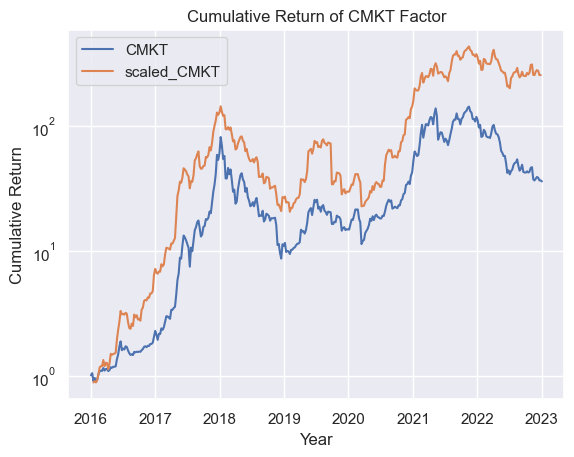

In [14]:
# Assuming CMKT_ret and scaled_liquid_Factors are pandas DataFrames/Series with appropriate data

# Plotting with logarithmic y-axis
plt.semilogy((1 + liquid_CMKT_ret.loc["2016":].CMKT).cumprod(), label='CMKT')
plt.semilogy((1 + scaled_liquid_Factors.loc["2016":].CMKT).cumprod(), label='scaled_CMKT')

# Adding labels and legend
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Return of CMKT Factor')
plt.legend()

# Save the plot
plt.savefig('Data/figure_2_CMKT.png')

# Display the plot
plt.show()

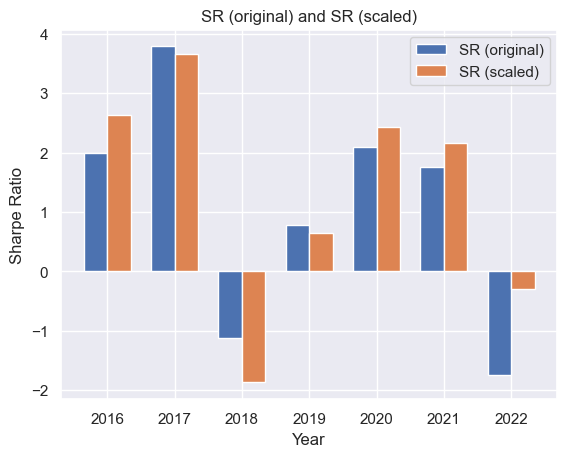

In [15]:
sns.set_theme()
# Your provided DataFrame
data = {'SR (original)': [1.990509, 3.787578, -1.116616, 0.786115, 2.097559, 1.750943, -1.740359],
        'SR (scaled)': [2.640456, 3.667965, -1.870679, 0.642712, 2.424526, 2.16382, -0.300648]}

Sharpe_ratio = pd.DataFrame(data, index=[2016, 2017, 2018, 2019, 2020, 2021, 2022])

# Plotting the paired barplot
fig, ax = plt.subplots()
bar_width = 0.35
index = range(len(Sharpe_ratio))

# Original SR bars
original_sr = ax.bar(index, Sharpe_ratio['SR (original)'], bar_width, label='SR (original)')

# Scaled SR bars
scaled_sr = ax.bar([i + bar_width for i in index], Sharpe_ratio['SR (scaled)'], bar_width, label='SR (scaled)')

# Adding labels, title, and legend
ax.set_xlabel('Year')
ax.set_ylabel('Sharpe Ratio')
ax.set_title('SR (original) and SR (scaled)')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(Sharpe_ratio.index)
ax.legend()

# Display the plot
plt.show()

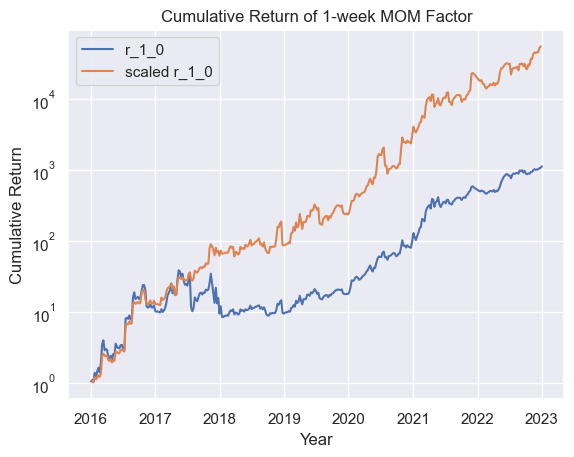

In [16]:
# Assuming r_1_0_ret and scaled_liquid_Factors are pandas DataFrames/Series with appropriate data

# Plotting with logarithmic y-axis
plt.semilogy((1 + liquid_r_1_0_ret.loc["2016":].r_1_0).cumprod(), label='r_1_0')
plt.semilogy((1 + scaled_liquid_Factors.loc["2016":].r_1_0).cumprod(), label='scaled r_1_0')

# Adding labels and legend
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Return of 1-week MOM Factor')
plt.legend()

# Save the plot
plt.savefig('Data/figure_2_r_1_0.png')

# Display the plot
plt.show()

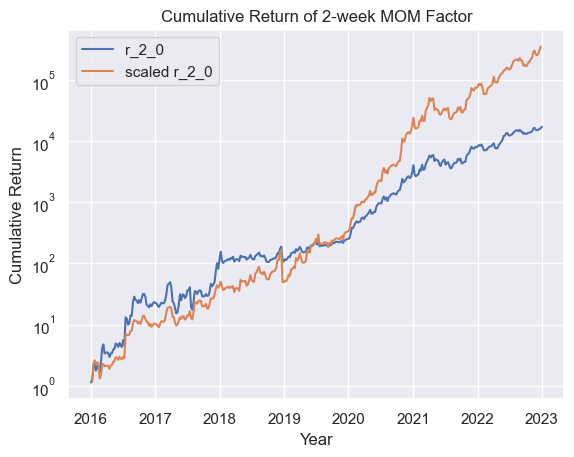

In [17]:
# Assuming r_1_0_ret and scaled_liquid_Factors are pandas DataFrames/Series with appropriate data

# Plotting with logarithmic y-axis
plt.semilogy((1 + liquid_r_2_0_ret.loc["2016":].r_2_0).cumprod(), label='r_2_0')
plt.semilogy((1 + scaled_liquid_Factors.loc["2016":].r_2_0).cumprod(), label='scaled r_2_0')

# Adding labels and legend
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Return of 2-week MOM Factor')
plt.legend()

# Save the plot
plt.savefig('Data/figure_2_r_2_0.png')

# Display the plot
plt.show()

<span id="long-strategies" style="font-size: 14px; font-weight: bold; color: purple;">long strategies:</span>

In [18]:
long_r_1_0 = ret_W[liquidity_filter]
long_r_1_0_weight = vmp.calculate_weights(long_r_1_0, weekend_marketCap, weekly_Volume)[liquidity_filter_2]
long_r_1_0_ret = vmp.calculate_portfolio_returns(ret_W, long_r_1_0_weight, factor="r_1_0")
long_r_1_0_weight_D = long_r_1_0_weight.resample("D").bfill(limit=6)[liquidity_filter_D]
long_r_1_0_ret_D = vmp.calculate_portfolio_returns(ret_D, long_r_1_0_weight_D, factor="r_1_0")

long_r_2_0 = ((weekend_price/weekend_price.shift(2))-1)[liquidity_filter]
long_r_2_0_weight = vmp.calculate_weights(long_r_2_0, weekend_marketCap, weekly_Volume)[liquidity_filter_2]
long_r_2_0_ret = vmp.calculate_portfolio_returns(ret_W, long_r_2_0_weight, factor="r_2_0")
long_r_2_0_weight_D = long_r_2_0_weight.resample("D").bfill(limit=6)[liquidity_filter_D]
long_r_2_0_ret_D = vmp.calculate_portfolio_returns(ret_D, long_r_2_0_weight_D, factor="r_2_0")

long_Factors_list = [long_r_1_0_ret, long_r_1_0_ret]
long_Factors = pd.concat(long_Factors_list, axis=1)
long_Factors_D_list = [long_r_1_0_ret_D, long_r_2_0_ret_D]
long_Factors_D = pd.concat(long_Factors_D_list, axis=1)

In [19]:
r_1_0_W,r_1_0_D = vmp.factor_portfolio(r_1_0.loc["2016":], weekend_marketCap, weekly_Volume, ret_W, ret_D, q=5)
r_2_0_W,r_2_0_D = vmp.factor_portfolio(r_2_0.loc["2016":], weekend_marketCap, weekly_Volume, ret_W, ret_D, q=5)

long_Factors_list = [r_1_0_W[5], r_2_0_W[5]]
long_Factors = pd.concat(long_Factors_list, axis=1)
long_Factors_D_list = [r_1_0_D[5], r_2_0_D[5]]
long_Factors_D = pd.concat(long_Factors_D_list, axis=1)
long_Factors.columns = ["r_1_0","r_2_0"]
long_Factors_D.columns = ["r_1_0","r_2_0"]

F:\test\bot_1\Lib\site-packages\numpy\lib\function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [20]:
scaled_long_Factors = vmp.VMP(long_Factors_D.loc["2016":"2022"],long_Factors.loc["2016":"2022"],how='std')
x = vmp.calculate_financial_statistics(scaled_long_Factors,RF_D) - vmp.calculate_financial_statistics(long_Factors.loc["2016":"2022"],RF_D)
x["p-value"] = scaled_long_Factors.apply(lambda col: vmp.jobson_korkie_test(col,long_Factors[col.name]))
x = x.loc[:,["Mean Excess Returns", "Sharpe Ratio", "p-value"]]
x.columns = ["R(Scaled) - R(Original)","SR2-SR1","p-value"]
x

,R(Scaled) - R(Original),SR2-SR1,p-value
r_1_0,-0.005156,-0.187750,0.849646
r_2_0,-0.010939,-0.386318,0.294655
